In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
tf.random.set_seed(3)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from collections import Counter
from tensorflow.keras.models import load_model

In [2]:
pip install --upgrade requests

Note: you may need to restart the kernel to use updated packages.


In [3]:
data_dir = '/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)'
output_dir = '/kaggle/input/ddd-dataset'
train_dir = "/kaggle/input/ddd-dataset/train"
test_dir = "/kaggle/input/ddd-dataset/test"
val_dir = "/kaggle/input/ddd-dataset/val"

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_batches = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

Found 33434 images belonging to 2 classes.


In [6]:
test_batches = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary' ,
    shuffle=True
)

Found 2091 images belonging to 2 classes.


In [7]:
val_batches = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

Found 6268 images belonging to 2 classes.


In [8]:
train_class_indices = train_batches.class_indices
test_class_indices = test_batches.class_indices
val_class_indices = val_batches.class_indices

train_class_labels = train_batches.classes
test_class_labels = test_batches.classes
val_class_labels = val_batches.classes


train_class_counts = Counter(train_class_labels)
test_class_counts = Counter(test_class_labels)
val_class_counts = Counter(val_class_labels)

print("Class Names for train:\n", train_class_indices)
print("Class Counts for train:\n", train_class_counts)
print(end='\n')

print("Class Names for test:\n", test_class_indices)
print("Class Counts for test:\n", test_class_counts)
print(end='\n')

print("Class Names for validation :\n", val_class_indices)
print("Class Counts for validation:\n", val_class_counts)


Class Names for train:
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for train:
 Counter({0: 17878, 1: 15556})

Class Names for test:
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for test:
 Counter({0: 1118, 1: 973})

Class Names for validation :
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for validation:
 Counter({0: 3352, 1: 2916})


Pixels of the first image after Normalization: 

[[[0.9921569  0.9960785  0.98823535]
  [0.9921569  0.9960785  0.98823535]
  [0.9921569  0.9960785  0.98823535]
  ...
  [0.6392157  0.6039216  0.56078434]
  [0.64705884 0.6117647  0.5686275 ]
  [0.6745098  0.6431373  0.6       ]]

 [[0.9921569  0.9960785  0.98823535]
  [0.9921569  0.9960785  0.98823535]
  [0.9921569  0.9960785  0.98823535]
  ...
  [0.64705884 0.6117647  0.5686275 ]
  [0.6666667  0.627451   0.5882353 ]
  [0.68235296 0.64705884 0.6039216 ]]

 [[0.9921569  0.9960785  0.98823535]
  [0.9921569  0.9960785  0.98823535]
  [0.9921569  0.9960785  0.98823535]
  ...
  [0.654902   0.61960787 0.5803922 ]
  [0.6627451  0.627451   0.5882353 ]
  [0.67058825 0.6431373  0.6       ]]

 ...

 [[0.7254902  0.6901961  0.62352943]
  [0.7058824  0.6745098  0.6039216 ]
  [0.7058824  0.6745098  0.6039216 ]
  ...
  [0.73333335 0.7137255  0.65882355]
  [0.7176471  0.69803923 0.6431373 ]
  [0.7372549  0.7176471  0.6627451 ]]

 [[0.7176471  0.68235296 

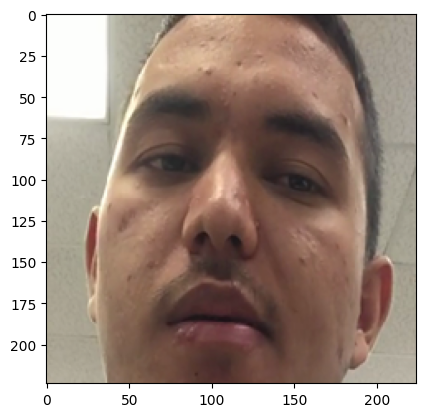

In [9]:
images, labels = next(train_batches)
print(f"Pixels of the first image after Normalization: \n\n{images[0]}") #print pixels of the first img
plt.imshow(images[0])
plt.show()

In [10]:
print(f"there are { images[0].ndim} Channels ")
print(f"image shape : {images[0].shape}")

there are 3 Channels 
image shape : (224, 224, 3)


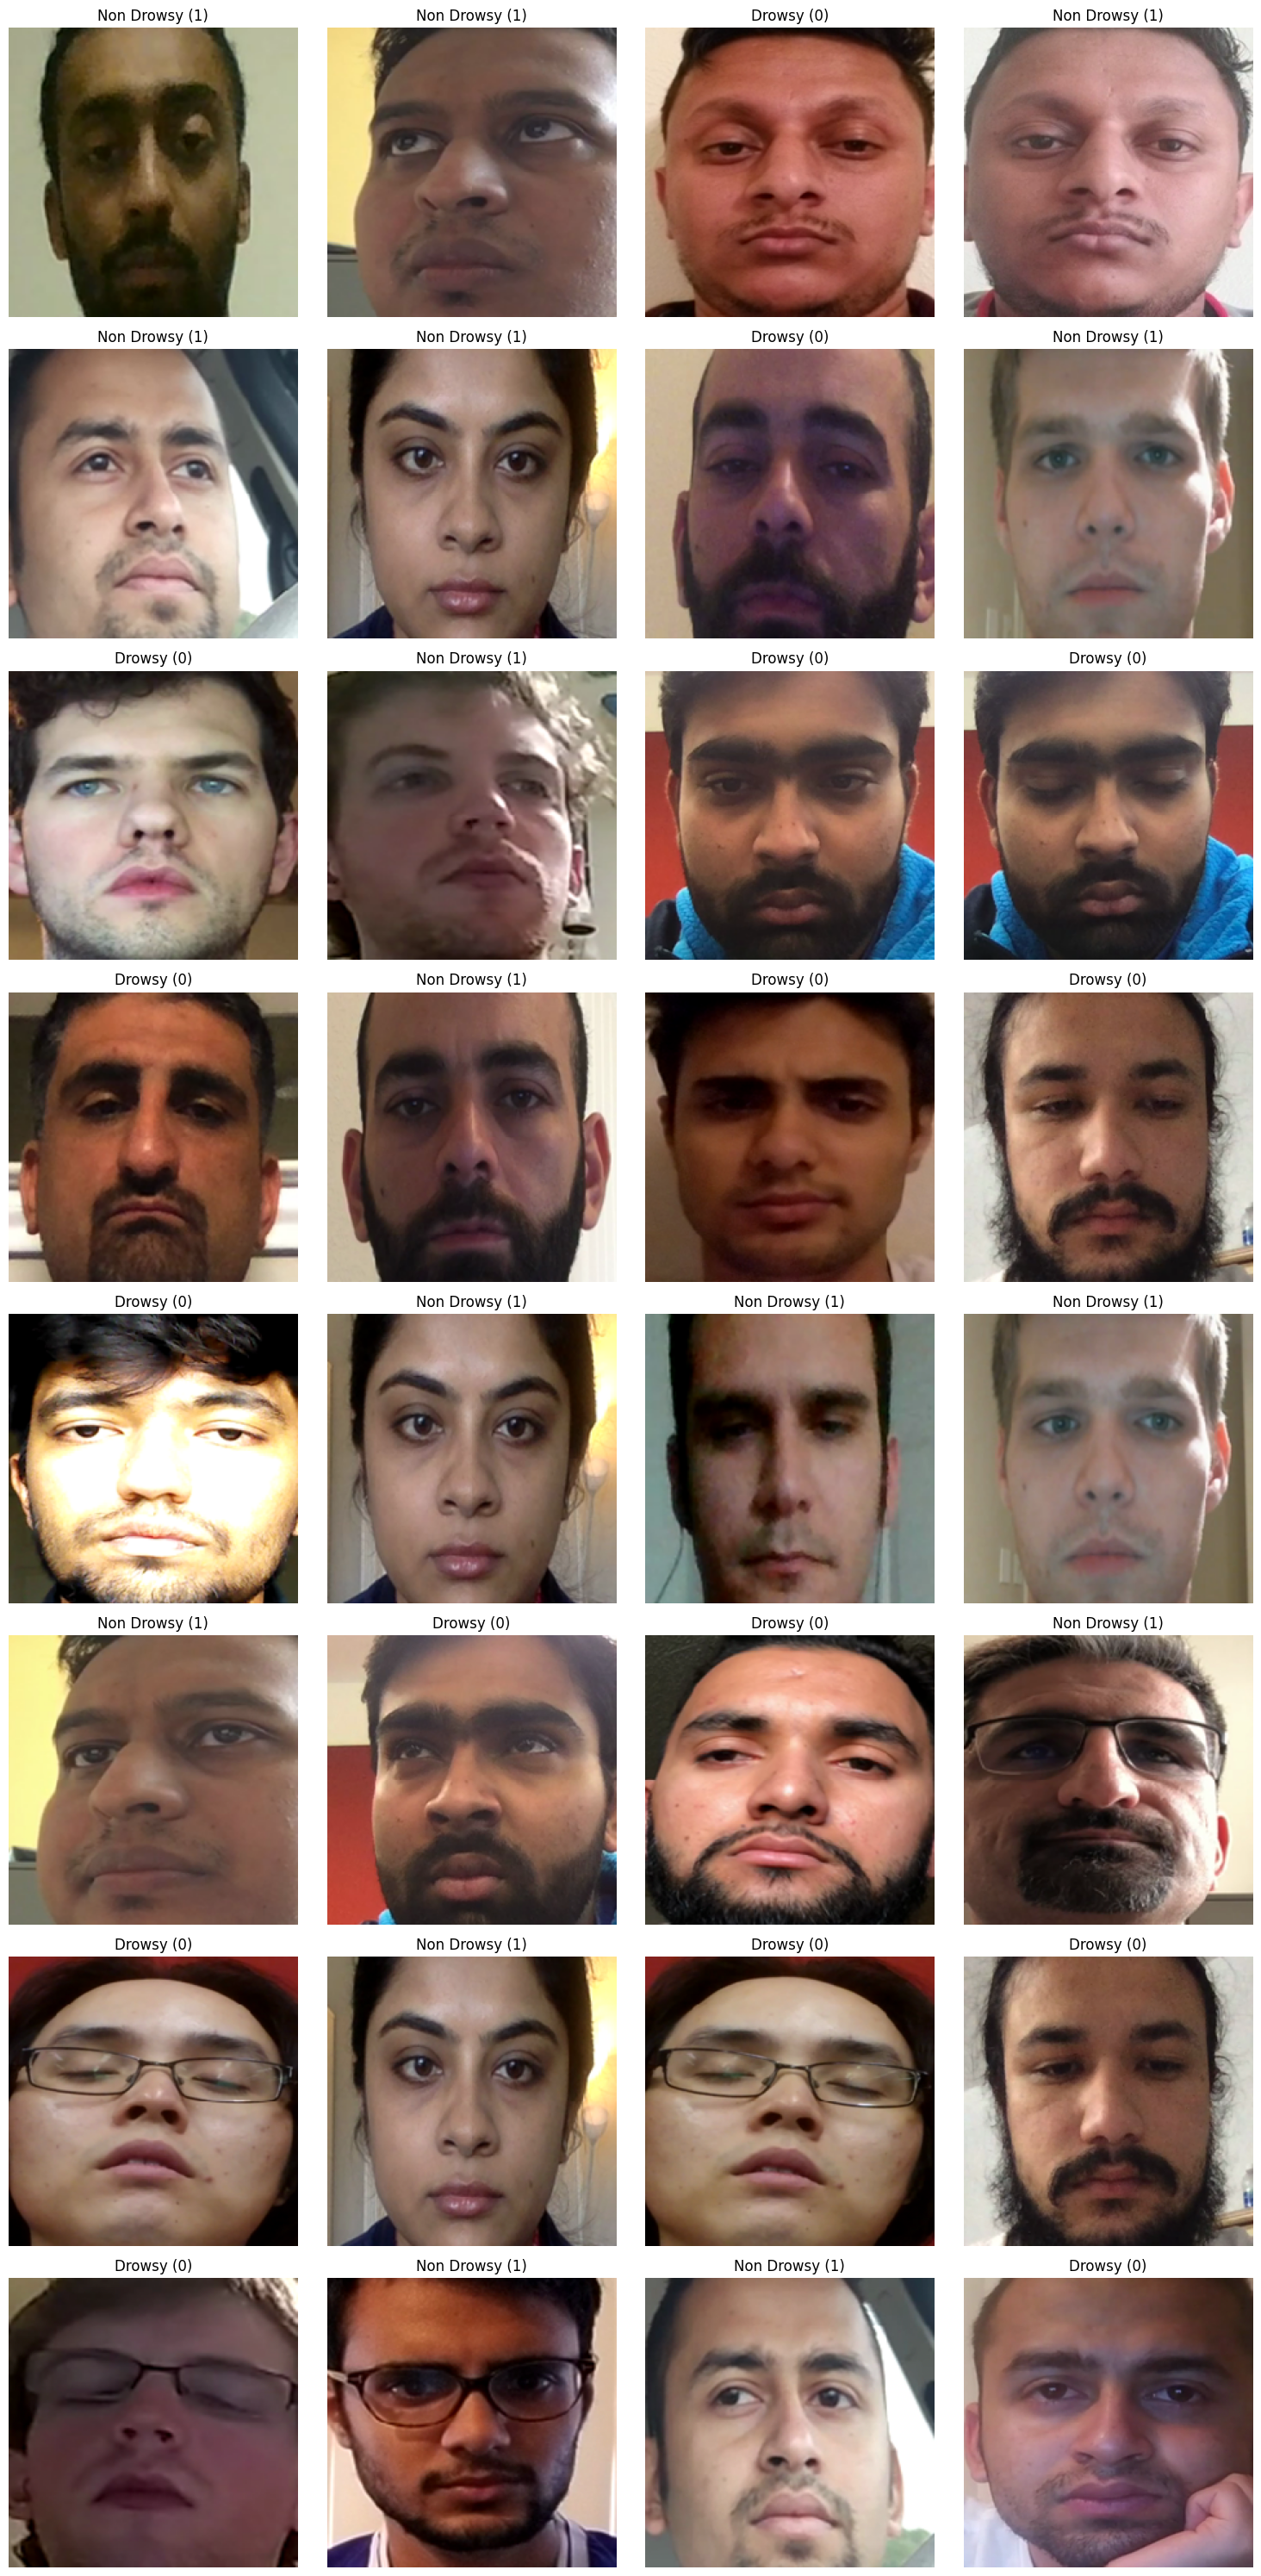

In [11]:
fig, axes = plt.subplots(8, 4, figsize=(15, 30))
class_indices = train_batches.class_indices

for i in range(8):
    images, labels = next(train_batches)
    for j in range(4):
        
        ax = axes[i, j]
        ax.imshow(images[j])
        ax.axis('off')
        label = int(labels[j])  
        label_name = list(class_indices.keys())[list(class_indices.values()).index(label)]
        ax.set_title(f'{label_name} ({label})')

plt.tight_layout()
plt.show()


In [12]:
base_model = MobileNetV2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3),
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [13]:
type(base_model)

keras.src.models.functional.Functional

In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [15]:
model=keras.Sequential() #empty

In [16]:
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

In [17]:
model = Model(inputs=base_model.input, outputs=predictions)

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 67,010,114 (255.62 MB)

 Trainable params: 66,976,002 (255.49 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [19]:
model.compile(optimizer=Adam(0.0001 ), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
history = model.fit(
   train_batches,
    epochs=10,
    validation_data=val_batches,
    batch_size=32
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 322s 133ms/step - accuracy: 0.9762 - loss: 0.1093 - val_accuracy: 0.9861 - val_loss: 0.0460
Epoch 2/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 177s 84ms/step - accuracy: 0.9973 - loss: 0.0183 - val_accuracy: 0.9997 - val_loss: 0.0012
Epoch 3/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 176s 84ms/step - accuracy: 0.9979 - loss: 0.0140 - val_accuracy: 0.9797 - val_loss: 0.1517
Epoch 4/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 176s 84ms/step - accuracy: 0.9968 - loss: 0.0169 - val_accuracy: 0.9979 - val_loss: 0.0134
Epoch 5/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 176s 84ms/step - accuracy: 0.9988 - loss: 0.0078 - val_accuracy: 0.9989 - val_loss: 0.0064
Epoch 6/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 175s 83ms/step - accuracy: 0.9986 - loss: 0.0135 - val_accuracy: 0.9994 - val_loss: 0.0026
Epoch 7/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 175s 84ms/step - accuracy: 0.9995 - loss: 0.0033 - val_accuracy: 0.9990 - val_loss: 0.0050
Epoch 8/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 176s 84ms/step - accuracy: 0.9991 - l

In [21]:
model.save('/kaggle/working/mobilenet_ddd.h5')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.623077 to fit



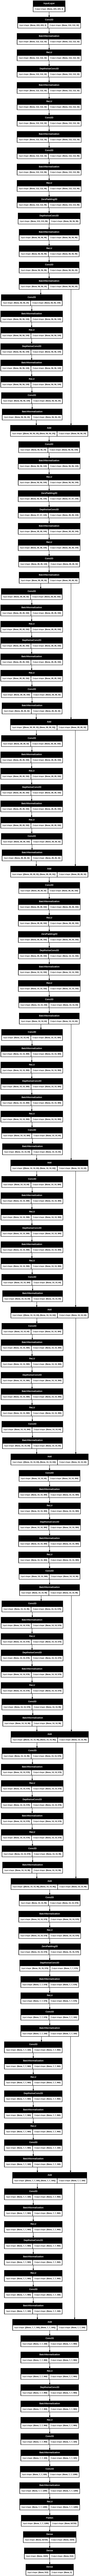

In [22]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [23]:
loss, accuracy = model.evaluate(train_batches)

print(f"Training Loss: {loss:.4f}")
print(f"Training Accuracy: {accuracy*100:.2f}%")

2090/2090 ━━━━━━━━━━━━━━━━━━━━ 130s 62ms/step - accuracy: 1.0000 - loss: 9.5488e-06
Training Loss: 0.0000
Training Accuracy: 100.00%


In [24]:
loss, accuracy = model.evaluate(test_batches)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

131/131 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.9979 - loss: 0.0048
Test Loss: 0.0011
Test Accuracy: 99.95%


In [25]:
y_pred = model.predict(test_batches)

y_pred_labels = np.argmax(y_pred, axis=1)

131/131 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step


In [26]:
y_actual = test_batches.labels

In [27]:
conf_matrix = confusion_matrix(y_actual, y_pred_labels)

print(conf_matrix)

[[591 527]
 [528 445]]


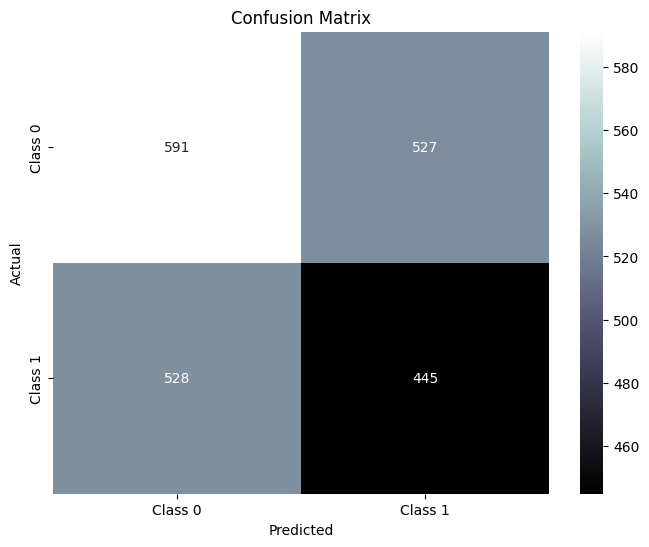

In [28]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='bone', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [29]:
report = classification_report(y_actual, y_pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.53      0.53      0.53      1118
           1       0.46      0.46      0.46       973

    accuracy                           0.50      2091
   macro avg       0.49      0.49      0.49      2091
weighted avg       0.50      0.50      0.50      2091

